In [44]:
from pathlib import Path

import numpy as np
import pandas as pd


In [45]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator


In [46]:
import os
import threadpoolctl
import warnings

from rectools.models import ImplicitALSWrapperModel
from rectools.dataset import Dataset
from implicit.als import AlternatingLeastSquares

warnings.filterwarnings('ignore')

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

In [47]:
from src.utils import processing, calculate_recall

In [48]:
catalog = pd.read_parquet(f'{Path.cwd().parent}/data/stokman_catalog_preprocessed.pq', engine='pyarrow')
catalog.head()

,add_date,shop_id,product_id,category_id,price,title,old_price
0,2024-09-30 03:07:09,350,1025536,8922,6990,6048 48557 44342 53515 17614,6990
1,2024-09-19 03:07:08,350,1025614,10600,330,42548 40244 23485 10853 6545 2343,330
2,2024-09-30 03:07:09,350,1025656,231,13240,14034 42002 48557 56089 46836 55620 50785,26490
3,2024-09-30 03:07:09,350,1025659,14546,7550,32640 50164 48557 25314 23255 42146,12590
4,2024-09-30 03:07:09,350,1025668,1949,1290,51789 48557 56089 20149,1290


In [49]:
actions = pd.read_parquet(f'{Path.cwd().parent}/data/train_actions.pq', engine='pyarrow')
actions.head()

,user_id,loc_user_id,action,date,products,pageId
0,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:04,[],2571824865
1,6fd49b56-8cc6-11ed-86e0-002590c0647c,c6e357dc-121d-449d-a744-e9a0b56c2380,7,2024-09-07 00:00:08,[],3834364438
2,f9c498ec-5d3b-11ef-86e0-002590c0647c,120c9064-1131-4dc3-8048-44184531b42e,7,2024-09-07 00:00:08,[],2448628415
3,59386b5c-e64f-11ec-8086-002590c82437,f0745572-893f-4e50-bc52-5af47badff5a,7,2024-09-07 00:00:11,[],3875013967
4,badbd396-6cab-11ef-86e0-002590c0647c,73423d85-d47c-4332-8155-5200615302b5,7,2024-09-07 00:00:11,[],3025531174


#### Разворачиваем данные по айдишникам продуктов

In [50]:
_actions = (
    actions
    .copy()
    .explode('products')
    .assign(products=lambda x: x.products.fillna(-1).astype(np.int64))
)
print(_actions.shape)

_catalog = (
    catalog
    .copy()
    .assign(product_id=lambda x: x.product_id.astype(np.int64))
)

(6859002, 6)


#### Разворачиваем данные по айдишникам продуктов

In [51]:
_actions['action_datetime'] = pd.to_datetime(_actions['date'])

_actions.action = _actions.action + 10
_actions.action = _actions.action.replace({14: 0, 13: 1, 18: 2, 19: 3, 10: 5, 17: 4, 11: 6, 12: 7, 16: 8, 15: 9})
_actions = _actions.sort_values(by=['action', 'date'])
print(_actions.shape)

(6859002, 7)


#### Новая шкала action в train_actions.pq в порядке возрастания важности
    0 - clearB (удаление всех товаров из корзины)
    1 - delB (удаление товара из корзины)
    2 - visitCategory (посещение страницы с группой товаров)
    3 - search (поиск товара)           
    4 - visit (посещение страницы с товаром)
    5 - view (просмотр товара)
    6 - like (лайк товара)
    7 - addB (добавление товара в корзину)
    8 - listB (посещение страницы корзины и вывод списка товаров в корзине)
    9 - order (оформление заказа)
    

#### Переименовываем поля и обьеденияем датасеты каталога и дейсвтвий пользователя    
'products' теперь 'item_id', 'action'  превратился в 'weight' (мы перевели код действия в шкалу по возрастанию ранее)

In [52]:
interactions = _actions.rename(columns={'products': 'item_id', 'action' : 'weight', 'action_datetime': 'datetime'})
interactions = interactions[interactions['item_id'] != '/*']

In [53]:
items = _catalog.rename(columns={'product_id': 'item_id'})

In [54]:
interactions_merge = interactions.merge(items, on='item_id', how='left')
interactions_merge.shape

(6859002, 13)

In [55]:
interactions_merge['day'] = interactions_merge['datetime'].dt.day
interactions_merge['day_of_week'] = interactions_merge['datetime'].dt.dayofweek  # Monday=0, Sunday=6

interactions_merge['hour'] = interactions_merge['datetime'].dt.hour
interactions_merge['minute'] = interactions_merge['datetime'].dt.minute

In [56]:
interactions_merge['price_diff'] = interactions_merge['price'] - interactions_merge['old_price']

interactions_merge['category_id'] = interactions_merge['category_id'].fillna(0)
interactions_merge['price_diff'] = interactions_merge['price_diff'].fillna(0)

interactions_merge['category_id'] = interactions_merge['category_id'].astype(np.int32)

In [57]:
inters = interactions_merge.merge(
    interactions_merge.groupby('user_id')['loc_user_id'].count().reset_index(name='loc_user_count'),
    on='user_id',
    how='left'
)
print(inters.shape)

(6859002, 19)


In [58]:
inters = inters.merge(
    interactions_merge.groupby('user_id')['category_id'].count().reset_index(name='category_id_count'),
    on='user_id',
    how='left'
)
print(inters.shape)

(6859002, 20)


In [59]:
for action in sorted(interactions_merge.weight.unique()):
    inters = inters.merge(
        interactions_merge[interactions_merge.weight  == action].groupby('user_id')['weight'].count().reset_index(name=f'action_{action}_count'),
        on='user_id',
        how='left'
    )
    inters[f'action_{action}_count'] = inters[f'action_{action}_count'].fillna(0)
print(inters.shape)

(6859002, 30)


In [60]:
inters['delta_sec'] = inters.sort_values(by=['datetime']).groupby('user_id')['datetime'].diff()
inters['delta_sec'] = inters['delta_sec'].dt.total_seconds()
inters['delta_sec'] = inters['delta_sec'].fillna(0)

In [61]:
inters['delta_day'] = inters.sort_values(by=['datetime']).groupby('user_id')['day'].diff()
inters['delta_day'] = inters['delta_day'].fillna(0)

inters['delta_hour'] = inters.sort_values(by=['datetime']).groupby('user_id')['hour'].diff()
inters['delta_hour'] = inters['delta_hour'].fillna(0)

inters['delta_min'] = inters.sort_values(by=['datetime']).groupby('user_id')['minute'].diff()
inters['delta_min'] = inters['delta_min'].fillna(0)

In [62]:
inters = inters.drop(columns=['day', 'hour', 'minute'])

In [63]:
inters = inters.drop(columns=['price', 'title', 'old_price', 'date', 'add_date', 'loc_user_id', 'shop_id'])

In [64]:
inters[inters.user_id == 'e4362420-f6ca-11ec-86e0-002590c0647c'].head(500)

,user_id,weight,item_id,pageId,datetime,category_id,day_of_week,price_diff,loc_user_count,category_id_count,...,action_4_count,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min
27332,e4362420-f6ca-11ec-86e0-002590c0647c,2,-1,1731967912,2024-09-07 00:02:02,0,5,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
27334,e4362420-f6ca-11ec-86e0-002590c0647c,2,-1,1731967912,2024-09-07 00:02:05,0,5,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
27337,e4362420-f6ca-11ec-86e0-002590c0647c,2,-1,1731967912,2024-09-07 00:02:08,0,5,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
27347,e4362420-f6ca-11ec-86e0-002590c0647c,2,-1,1731967912,2024-09-07 00:03:03,0,5,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
27359,e4362420-f6ca-11ec-86e0-002590c0647c,2,-1,1731967912,2024-09-07 00:03:32,0,5,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6295889,e4362420-f6ca-11ec-86e0-002590c0647c,5,6770769,252042197,2024-09-27 06:14:04,50448,4,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
6295906,e4362420-f6ca-11ec-86e0-002590c0647c,5,6990711,252042197,2024-09-27 06:14:21,50448,4,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
6295912,e4362420-f6ca-11ec-86e0-002590c0647c,5,6770769,252042197,2024-09-27 06:14:25,50448,4,0.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
6847200,e4362420-f6ca-11ec-86e0-002590c0647c,9,5422963,4263215769,2024-09-07 00:01:12,2247,5,-5700.0,384,384,...,263.0,57.0,0.0,0.0,0.0,2.0,20.0,0.0,0.0,1.0


In [65]:
inters.head()

,user_id,weight,item_id,pageId,datetime,category_id,day_of_week,price_diff,loc_user_count,category_id_count,...,action_4_count,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min
0,5b08b2fc-0e71-11ee-86e0-002590c0647c,0,-1,89919732,2024-09-07 05:11:00,0,5,0.0,141,141,...,101.0,27.0,2.0,1.0,1.0,0.0,24.0,0.0,0.0,1.0
1,1af7e04c-6cd1-11ef-9b7b-002590c82436,0,-1,851020872,2024-09-07 05:50:01,0,5,0.0,91,91,...,47.0,25.0,0.0,2.0,5.0,1.0,6.0,0.0,0.0,1.0
2,d41cdad4-3b4c-11ef-86e0-002590c0647c,0,-1,1515288183,2024-09-07 07:37:02,0,5,0.0,85,85,...,48.0,14.0,0.0,2.0,6.0,0.0,8.0,0.0,0.0,1.0
3,59b9d89a-1de2-11eb-86e0-002590c0647c,0,-1,1497267364,2024-09-07 11:52:12,0,5,0.0,8270,8270,...,5244.0,694.0,1.0,125.0,1729.0,112.0,3.0,0.0,0.0,0.0
4,9c087566-8065-11ed-86e0-002590c0647c,0,-1,3039170152,2024-09-07 12:14:30,0,5,0.0,182,182,...,118.0,26.0,0.0,3.0,8.0,0.0,9.0,0.0,0.0,0.0


#### baseline filter v4.2 parameters:
 pd.Timedelta(5, unit='D') & (purchasers['weight'] > 7) & purchasers.iloc[purchasers.shape[0] - 3000:, :].item_id

In [66]:
last_5_days = inters['datetime'].max() - pd.Timedelta(5, unit='D')
purchasers = inters.sort_values(by=['datetime', 'weight'], ascending=True)
purchasers = purchasers[(purchasers['weight'] > 7) & (purchasers['datetime'] > last_5_days)]
purchasers = purchasers.groupby(['user_id'])['item_id'].apply(processing)
purchasers = purchasers.reset_index()
purchasers.shape

(3793, 2)

In [67]:
len(purchasers.user_id.unique())

3793

In [68]:
proved_ids = purchasers.iloc[purchasers.shape[0] - 3000:, :].item_id

In [69]:
purchasers = purchasers[purchasers.item_id.isin(proved_ids)]
print(purchasers.shape)
p = purchasers.iloc[purchasers.shape[0] - 3000:, :].reset_index(drop=True).rename(columns={'item_id': 'products'})
print(p.shape)
p.to_csv("predictions.csv", index=False)

(3052, 2)
(3000, 2)


In [70]:
print(pd.read_csv('predictions.csv').shape)
pd.read_csv('predictions.csv').sample(200)

(3000, 2)


,user_id,products
907,721769b6-80d6-11ee-86e0-002590c0647c,['6143023']
295,4b4a627e-0c94-11ec-8a53-0cc47a6d2fef,"['3633364', '6230464', '5280298', '6209083']"
1112,80659550-8cda-11ee-bbb1-002590c82437,"['1499234', '1470440', '6398419', '853819', '8..."
1879,b28267a4-a303-11ee-bbb1-002590c82436,['5386858']
1055,7cb99dc2-b82b-11ed-86e0-002590c0647c,['4867651']
...,...,...
2478,d9feed0e-52fb-11ef-9b7b-002590c82436,['5884027']
1486,973fd48a-3c1b-11ee-b1da-002590c82437,"['5883052', '4989073', '4888021']"
82,3c1f19fc-f34e-11eb-a6e9-002590c82437,['1411487']
1107,8011f5f2-db19-11ee-ad8e-002590c82436,"['3998541', '3845872', '698755', '698770', '87..."


#### Тренировка модели для распознования ключевого события

In [71]:
inters[inters.weight == 1]

,user_id,weight,item_id,pageId,datetime,category_id,day_of_week,price_diff,loc_user_count,category_id_count,...,action_4_count,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min
369,59386b5c-e64f-11ec-8086-002590c82437,1,5930062,298100564,2024-09-07 00:24:19,185,5,-2100.0,6273,6273,...,2174.0,863.0,89.0,141.0,2301.0,29.0,28.0,0.0,0.0,1.0
370,59386b5c-e64f-11ec-8086-002590c82437,1,5930059,298100564,2024-09-07 00:24:24,185,5,-2100.0,6273,6273,...,2174.0,863.0,89.0,141.0,2301.0,29.0,4.0,0.0,0.0,0.0
371,59386b5c-e64f-11ec-8086-002590c82437,1,5930065,298100564,2024-09-07 00:24:28,185,5,-2100.0,6273,6273,...,2174.0,863.0,89.0,141.0,2301.0,29.0,4.0,0.0,0.0,0.0
372,59386b5c-e64f-11ec-8086-002590c82437,1,1330052,298100564,2024-09-07 00:24:43,1139,5,-5300.0,6273,6273,...,2174.0,863.0,89.0,141.0,2301.0,29.0,14.0,0.0,0.0,0.0
373,59386b5c-e64f-11ec-8086-002590c82437,1,2061391,298100564,2024-09-07 00:25:02,1134,5,-2800.0,6273,6273,...,2174.0,863.0,89.0,141.0,2301.0,29.0,18.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27315,0fce28d6-0a6e-11ef-86e0-002590c0647c,1,6338047,531372315,2024-09-28 23:22:56,984,5,-1290.0,1491,1491,...,624.0,158.0,0.0,34.0,455.0,7.0,7.0,0.0,0.0,0.0
27316,9dbc652c-fd53-11ee-9b7b-002590c82436,1,5015896,2298361325,2024-09-28 23:36:13,6567,5,0.0,3802,3802,...,1259.0,431.0,8.0,248.0,1627.0,12.0,5.0,0.0,0.0,0.0
27317,9dbc652c-fd53-11ee-9b7b-002590c82436,1,5015908,2298361325,2024-09-28 23:36:21,6567,5,0.0,3802,3802,...,1259.0,431.0,8.0,248.0,1627.0,12.0,3.0,0.0,0.0,0.0
27318,0fce28d6-0a6e-11ef-86e0-002590c0647c,1,4942615,2198278090,2024-09-28 23:40:02,40321,5,0.0,1491,1491,...,624.0,158.0,0.0,34.0,455.0,7.0,0.0,0.0,0.0,0.0


In [72]:
max_date = inters['datetime'].max()
train_raw = inters[inters['datetime'] >= max_date - pd.Timedelta(days=22)].copy()
train_raw = train_raw[train_raw['datetime'] <= max_date - pd.Timedelta(days=3)]
test_raw = inters[inters['datetime'] > max_date - pd.Timedelta(days=3)].copy()

In [73]:
train = train_raw.drop(columns=['datetime', 'item_id', 'pageId'])
test = test_raw.drop(columns=['datetime', 'item_id', 'pageId'])

In [74]:
test.sample()

,user_id,weight,category_id,day_of_week,price_diff,loc_user_count,category_id_count,action_0_count,action_1_count,action_2_count,...,action_4_count,action_5_count,action_6_count,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min
4877676,14e36526-e785-11ea-8a53-0cc47a6d2fef,4,0,3,0.0,1945,1945,0.0,28.0,113.0,...,815.0,249.0,64.0,60.0,572.0,35.0,88483.0,1.0,1.0,-26.0


In [75]:
train.shape, test.shape

((5796585, 21), (1062417, 21))

### Классы не сбалансированы

In [76]:
train.weight.value_counts()

weight
4    3555015
2     876037
5     875685
8     314938
3      69354
7      44249
6      26346
1      24150
9      10478
0        333
Name: count, dtype: int64

### Кооректируем баланс классов

In [77]:
train = train[train.weight.isin([0, 1, 3, 6, 7, 9])].drop_duplicates()
train.shape

(130257, 21)

In [78]:
train_portion = pd.concat(
    [
        train[train.weight.isin([0, 1, 3, 6, 7, 9])],
        train_raw.sample(130_000)],
    axis='rows'
)

In [79]:
train_portion.weight.unique()

array([0, 1, 3, 6, 7, 9, 4, 5, 2, 8])

In [80]:
h2o.init(verbose=False)
print(f'{h2o.cluster().show_status()}')
h2o.no_progress()

H2O_cluster_uptime:,4 mins 40 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_varsey_7edqlw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.612 Gb
H2O_cluster_total_cores:,20
H2O_cluster_allowed_cores:,20
H2O_cluster_status:,"locked, healthy"


None


In [81]:
train_portion[train_portion.weight == 0]

,user_id,weight,category_id,day_of_week,price_diff,loc_user_count,category_id_count,action_0_count,action_1_count,action_2_count,...,action_7_count,action_8_count,action_9_count,delta_sec,delta_day,delta_hour,delta_min,item_id,pageId,datetime
0,5b08b2fc-0e71-11ee-86e0-002590c0647c,0,0,5,0.0,141,141,1.0,0.0,8.0,...,1.0,1.0,0.0,24.0,0.0,0.0,1.0,NaN,NaN,NaT
1,1af7e04c-6cd1-11ef-9b7b-002590c82436,0,0,5,0.0,91,91,1.0,0.0,9.0,...,2.0,5.0,1.0,6.0,0.0,0.0,1.0,NaN,NaN,NaT
2,d41cdad4-3b4c-11ef-86e0-002590c0647c,0,0,5,0.0,85,85,2.0,0.0,13.0,...,2.0,6.0,0.0,8.0,0.0,0.0,1.0,NaN,NaN,NaT
3,59b9d89a-1de2-11eb-86e0-002590c0647c,0,0,5,0.0,8270,8270,2.0,44.0,250.0,...,125.0,1729.0,112.0,3.0,0.0,0.0,0.0,NaN,NaN,NaT
4,9c087566-8065-11ed-86e0-002590c0647c,0,0,5,0.0,182,182,1.0,1.0,25.0,...,3.0,8.0,0.0,9.0,0.0,0.0,0.0,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,2e8fd470-c1bf-11ed-a1c4-002590c82437,0,0,0,0.0,1144,1144,2.0,2.0,242.0,...,8.0,15.0,1.0,4.0,0.0,0.0,0.0,-1.0,3457196049,2024-09-16 17:29:44
317,5ff81ef6-774d-11ef-9b7b-002590c82436,0,0,2,0.0,275,275,1.0,0.0,38.0,...,3.0,8.0,0.0,26.0,0.0,0.0,0.0,-1.0,2906563291,2024-09-25 05:15:29
326,3f164334-8f3b-11ee-86e0-002590c0647c,0,0,2,0.0,1735,1735,1.0,0.0,290.0,...,6.0,15.0,5.0,3.0,0.0,0.0,0.0,-1.0,3220809990,2024-09-25 13:39:40
315,803a1848-57e3-11ee-86e0-002590c0647c,0,0,1,0.0,797,797,1.0,5.0,107.0,...,10.0,155.0,0.0,4.0,0.0,0.0,0.0,-1.0,336201369,2024-09-24 23:32:37


In [82]:
train_h2o = h2o.H2OFrame(train_portion)
test_h2o = h2o.H2OFrame(test.sample(40_000))

In [83]:
y = "weight"
x = set(train_h2o.names) - set([y, 'user_id', 'shop_id', 'day', 'hour', 'pageId', 'datetime', 'item_id', 'is_useful'])
x

{'action_0_count',
 'action_1_count',
 'action_2_count',
 'action_3_count',
 'action_4_count',
 'action_5_count',
 'action_6_count',
 'action_7_count',
 'action_8_count',
 'action_9_count',
 'category_id',
 'category_id_count',
 'day_of_week',
 'delta_day',
 'delta_hour',
 'delta_min',
 'delta_sec',
 'loc_user_count',
 'price_diff'}

In [84]:
train_h2o[y] = train_h2o[y].asfactor()
test_h2o[y] = test_h2o[y].asfactor()

In [85]:
train_h2o['category_id'] = train_h2o['category_id'].asfactor()
test_h2o['category_id'] = test_h2o['category_id'].asfactor()

### для снижения уровня рутины и фокусировки на цели - качесвтенных предсказаниях - используем automl

In [86]:
gbm_model = H2OGradientBoostingEstimator(seed=1234)
gbm_model.train(x=list(x), y=y, training_frame = train_h2o,  validation_frame = test_h2o, max_runtime_secs=120)

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1728682052778_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 500                         247229                 5            5            5             10            32            31.136

ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 0.2867341540717459
RMSE: 0.5354756334995514
LogLoss: 0.829765397764338
Mean Per-Class Error: 0.5117016881173684
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1      2    3      4       5      6      7      8    9     Error     Rate
---  -----  ---  -----  ------  -----  -----  -----  ---  ----  --------  ----------------
98   0      0    40     194     0      1      1      0    0     0.706587  236 / 334
1    9967   0    194    1230    106    2021   9246   133  330   0.570906  13,261 / 23,228
4    1      383  3080   16017   0      27     0      1    0     0.980372  19,130 / 19,513
2    0      0    26262  4895    0      44     0      0    0     0.15835   4,941 / 31,203
39   4      203  7948   71561   0      190    8      2    0     0.104984  8,394 / 79,955
0    1129   0    197    1389    11750  1318   3446   64   326   0.401091  7,869 / 19,619
1    975    0    229    1772    162    20236  2661   35   139   0.227928  5,974 / 26,210
3    4857   0    284    2290    284    4074   30264  102  1694  0.30986   13,588 / 43,852
0    2149   0    57     412     110    529    3010   463  218   0.933362  6,485 / 6,948
0    765    0    76     454     50     819    4630   4    2597  0.723576  6,798 / 9,395
148  19847  586  38367  100214  12462  29259  53266  804  5304  0.33304   86,676 / 260,257

Top-10 Hit Ratios: 
k    hit_ratio
---  -----------
1    0.66696
2    0.876856
3    0.951709
4    0.980788
5    0.992995
6    0.997798
7    0.999143
8    0.999823
9    0.999988
10   1

ModelMetricsMultinomial: gbm
** Reported on validation data. **

MSE: 0.26657422499090866
RMSE: 0.5163082654683233
LogLoss: 0.8089158164434042
Mean Per-Class Error: 0.4636855891295541
AUC table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).
AUCPR table was not computed: it is either disabled (model parameter 'auc_type' was set to AUTO or NONE) or the domain size exceeds the limit (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class
0    1    2    3     4      5     6     7     8    9    Error      Rate
---  ---  ---  ----  -----  ----  ----  ----  ---  ---  ---------  ---------------
0    0    0    0     0      0     0     0     0    0    nan        0 / 0
0    36   0    2     12     1     10    51    0    2    0.684211   78 / 114
1    0    132  872   5186   0     14    0     0    0    0.978727   6,073 / 6,205
0    0    0    363   64     0     0     0     0    0    0.149883   64 / 427
8    2    72   2248  22370  0     94    0     0    0    0.0977656  2,424 / 24,794
0    227  0    107   756    3628  508   900   15   91   0.417843   2,604 / 6,232
0    5    0    11    86     2     209   24    0    1    0.381657   129 / 338
0    12   0    2     13     0     28    147   0    8    0.3        63 / 210
0    349  0    22    72     26    160   846   102  45   0.937115   1,520 / 1,622
0    3    0    2     4   

In [87]:
gbm_model.varimp(use_pandas=True)

,variable,relative_importance,scaled_importance,percentage
0,category_id,190725.203125,1.000000,0.447355
1,action_6_count,50466.527344,0.264603,0.118372
2,action_3_count,46139.019531,0.241914,0.108221
3,action_7_count,31992.691406,0.167742,0.075040
4,action_1_count,23118.296875,0.121213,0.054225
5,action_4_count,20491.849609,0.107442,0.048065
6,delta_min,18280.353516,0.095847,0.042877
7,action_8_count,17567.078125,0.092107,0.041204
8,loc_user_count,7759.922852,0.040686,0.018201
9,action_9_count,6051.399902,0.031728,0.014194


In [88]:
gbm_model.model_performance(test_h2o)

0,1,2,3,4,5,6,7,8,9,Error,Rate
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,nan,0 / 0
0.0,36.0,0.0,2.0,12.0,1.0,10.0,51.0,0.0,2.0,0.6842105,78 / 114
1.0,0.0,132.0,872.0,5186.0,0.0,14.0,0.0,0.0,0.0,0.9787268,"6,073 / 6,205"
0.0,0.0,0.0,363.0,64.0,0.0,0.0,0.0,0.0,0.0,0.1498829,64 / 427
8.0,2.0,72.0,2248.0,22370.0,0.0,94.0,0.0,0.0,0.0,0.0977656,"2,424 / 24,794"
0.0,227.0,0.0,107.0,756.0,3628.0,508.0,900.0,15.0,91.0,0.4178434,"2,604 / 6,232"
0.0,5.0,0.0,11.0,86.0,2.0,209.0,24.0,0.0,1.0,0.3816568,129 / 338
0.0,12.0,0.0,2.0,13.0,0.0,28.0,147.0,0.0,8.0,0.3,63 / 210
0.0,349.0,0.0,22.0,72.0,26.0,160.0,846.0,102.0,45.0,0.9371147,"1,520 / 1,622"
0.0,3.0,0.0,2.0,4.0,1.0,3.0,27.0,0.0,18.0,0.6896552,40 / 58


#### Выбираем только категории с количеством товаров > N (для использования в качестве фильтра в дальнейшем)

In [119]:
cats = inters.category_id.value_counts()
cats = cats.reset_index()
# cats.category_id = cats.category_id.astype(int)
print(cats.columns)
selected_cat = cats[(cats['count'] > 50) & (cats['count'] != 0)].category_id.to_list()
len(selected_cat)

Index(['category_id', 'count'], dtype='object')


889

<Axes: >

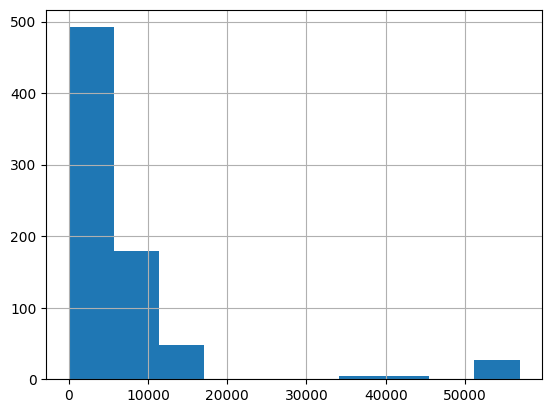

In [120]:
# Смотрим распределение частоты категории 
cats[(cats['count'] > 100) & (cats['count'] != 0)]['category_id'].hist(bins=10)

#### Расчитываем recall для локальных тестов

#### Тестовые данные - три дня и ключевое событие - 9 (заказ)

In [121]:
last_3_days = inters['datetime'].max() - pd.Timedelta(3, unit='D')
test_purchasers = inters.sort_values(by=['datetime', 'weight'], ascending=True)
test_purchasers = test_purchasers[(test_purchasers['weight'] == 9) & (test_purchasers['datetime'] > last_3_days)]
test_purchasers = test_purchasers.groupby(['user_id'])['item_id'].apply(processing)
test_purchasers = test_purchasers.reset_index()
test_purchasers.shape

(496, 2)

#### Предсказания фильтрацией

In [137]:
last_3_days = inters['datetime'].max() - pd.Timedelta(3, unit='D')
last_8_days = inters['datetime'].max() - pd.Timedelta(8*24, unit='hours')
pred_purchasers = inters.sort_values(by=['datetime', 'weight'], ascending=True)
pred_purchasers = pred_purchasers[
    (pred_purchasers['weight'] > 7)
    & (pred_purchasers['datetime'] > last_8_days)
    & (pred_purchasers['datetime'] < last_3_days)
    & ((pred_purchasers.action_7_count > 20) | (pred_purchasers.action_8_count > 50) | (pred_purchasers.action_9_count > 0))
]
pred_purchasers = pred_purchasers.groupby(['user_id'])['item_id'].apply(processing)
pred_purchasers = pred_purchasers.reset_index()
pred_purchasers.shape

(1561, 2)

#### Проверяем сколько пользователей из теста удалось "зацепить" фильтрацией

In [138]:
pred_purchasers[pred_purchasers.user_id.isin(test_purchasers.user_id.unique())].shape

(163, 2)

In [139]:
check_merge = test_purchasers.merge(pred_purchasers[-3000:], on='user_id', how='left')
check_merge.item_id_y.loc[check_merge.item_id_y.isnull()] = check_merge.item_id_y.loc[check_merge.item_id_y.isnull()].apply(lambda x: [])
check_merge.shape

(496, 3)

In [140]:
check_merge.sample(1)

,user_id,item_id_x,item_id_y
264,7e23458c-68e2-11ef-9b7b-002590c82436,"[1049443, 6272473]",[1049443]


In [141]:
#### Проверяем полноту фильтрации

In [142]:
check_merge['recall'] = check_merge.apply(calculate_recall, axis=1)
check_merge['recall'].mean()

0.05989834538221635

In [143]:
print(pred_purchasers.shape)
p = pred_purchasers.iloc[pred_purchasers.shape[0] - 3000:, :].reset_index(drop=True).rename(columns={'item_id': 'products'})
print(p.shape)
p.to_csv("predictions.csv", index=False)

(1561, 2)
(1439, 2)


#### Используем классификатор чтобы предсказать пользователей с целевыми дейсвтиями

In [144]:
inters['datetime'].min(), inters['datetime'].max()

(Timestamp('2024-09-07 00:00:04'), Timestamp('2024-09-28 23:59:59'))

In [146]:
last_3_days = inters['datetime'].max() - pd.Timedelta(3, unit='D')
last_8_days = inters['datetime'].max() - pd.Timedelta(10, unit='D')
pred_data = inters[(inters['datetime'] > last_8_days) & (inters['datetime'] < last_3_days)]

In [147]:
t = h2o.H2OFrame(pred_data[list(x)])

In [148]:
preds = gbm_model.predict(t)

#### Обьедтняем предсказания с исходными данными чтобы фильровать дальше

In [149]:
res = pd.concat(
    [
        pred_data[list(x) + ['weight', 'user_id', 'item_id']].reset_index(drop=True),
        preds.as_data_frame().reset_index(drop=True)
    ],
    axis='columns',
)

In [150]:
# Максимальный скор с которым предсказали целевое действие
res['score'] = res[res.columns[-10:]].max(axis=1)
        

In [151]:
# Смотрим корреляцию по данным чтобы понять по чему фильтровать
# res[list(set(res.columns) - set(['user_id']))].sample(1000).corr()

In [153]:
# Оцениваем размер таблицы после фильрации
res[
    (res.predict > 5) & (res.category_id.isin(selected_cat)) 
].groupby('user_id')['item_id'].agg(lambda x: list(map(str, x))[:25]).reset_index().shape

(8192, 2)

In [154]:
# Оцениваем количество пользователей, которое удалось "зацепить" фильтрацией из теста
res[
    (res.predict > 6)
    & (res.predict <= 7)
    & (res.category_id.isin(selected_cat))
    & (res.user_id.isin(test_purchasers.user_id.unique()))
    # & ((res.action_7_count > 1) | (res.action_8_count > 1) | (res.action_9_count > 1))
].groupby('user_id')['item_id'].agg(lambda x: list(set(map(str, x)))[:25]).reset_index().shape

(220, 2)

In [155]:
# Генерим таблицу с кандидатами по результатам мл - предсказания
ml_pred = res[
    (res.predict > 6)
    & (res.predict <= 7)
    & (res.category_id.isin(selected_cat))
    # & ((res.action_7_count > 1) | (res.action_8_count > 1) | (res.action_9_count > 1))
].groupby('user_id')['item_id'].agg(lambda x: list(set(map(str, x)))[:25]).reset_index()
ml_pred.shape

(6374, 2)

In [156]:
# Напоминание о размере таблицы с кандидатами после обычной фильтрации - оставшееся от 3000 строк место мы заполнили результатами мл
pred_purchasers.shape

(1561, 2)

In [157]:

data_to_check = pd.concat(
    [
        ml_pred.reset_index(drop=True),
        pred_purchasers.reset_index(drop=True),
    ],
    axis='rows'
)
print(data_to_check.shape)
data_to_check = data_to_check.drop_duplicates(subset='user_id', keep='last') # .reset_index(drop=True)
print(data_to_check[data_to_check.user_id.isin(test_purchasers.user_id.unique())].shape)
data_to_check.shape

(7935, 2)
(252, 2)


(6709, 2)

In [158]:
# Ограничим резульат 3000 строк (как по условию). Так как данные обычной фильтрации эффективнее и они в конце обьединенных данных - ограничим с конца
data_to_check[-3000:].shape

(3000, 2)

#### Проверяем результат локально на данных фильтрация + мл

In [159]:
# check_merge_ml = test_purchasers.merge(data_to_check.sample(3000, random_state=42), on='user_id', how='left')
check_merge_ml = test_purchasers.merge(data_to_check[-3000:], on='user_id', how='left')
check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()] = check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()].apply(lambda x: [])
print(check_merge_ml.shape)
check_merge_ml['recall'] = check_merge_ml.apply(calculate_recall, axis=1)
check_merge_ml['recall'].mean()

(496, 3)


0.06679306356725713

In [160]:
print(data_to_check.shape)
p = data_to_check.iloc[:3000, :].reset_index(drop=True).rename(columns={'item_id': 'products'})
print(p.shape)
p.to_csv("predictions.csv", index=False)

(6709, 2)
(3000, 2)


### Построение рекомендаций 
дополним данные после фильрации товарами на основе "оценок" пользователей (ценность действия интерпретируем как оценку)

#### Построение модели

In [161]:
K_RECOS = 25
NUM_THREADS = 24
RANDOM_STATE = 32
ITERATIONS = 10

In [162]:
def make_base_model(factors: int, regularization: float, alpha: float, fit_features_together: bool=False):
    return ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            random_state=RANDOM_STATE,
            use_gpu=False,
            num_threads = NUM_THREADS,
            iterations=ITERATIONS),
        fit_features_together = fit_features_together,
        )

In [182]:
last_3_days = inters['datetime'].max() - pd.Timedelta(3, unit='D')
last_8_days = inters['datetime'].max() - pd.Timedelta(22, unit='D')
recos_data = inters[
    (inters['datetime'] > last_8_days)
    & (inters['datetime'] < last_3_days) 
    & ((inters['weight'] > 4) | (inters['weight'] == 1))   # дейсвтия ниже 5 не привязаны к товару, чтобы не рекомендовать -1 и сэкономить на размере входных данных - фильтруем
]

In [183]:
recos_data.weight.unique()

array([1, 5, 6, 7, 8, 9])

In [184]:
recs_dataset = Dataset.construct(
    interactions_df=recos_data[['user_id', 'item_id', 'weight', 'datetime']],
)

model = make_base_model(factors=256, regularization=0.2, alpha=100)
model.fit(recs_dataset)

In [258]:
recos = model.recommend(
    users=data_to_check[-3000:].user_id,
    dataset=recs_dataset,
    k=10,
    filter_viewed=False,
)

In [259]:
recos[recos.item_id == -1]

,user_id,item_id,score,rank


#### Дополняем данные с предыдущих предсказаний (фильтрация + ml) 

In [260]:
recos_agg = recos.groupby('user_id')['item_id'].agg(lambda x: list(map(str, x))).reset_index()

In [261]:
recos_agg.head()

,user_id,item_id
0,0038911e-79a3-11ef-9b7b-002590c82436,"[1758351, 1628891, 1624568, 928663, 2691970, 8..."
1,0080a4d2-61cc-11ec-86e0-002590c0647c,"[6645690, 1027066, 6598520, 5868226, 5894047, ..."
2,00a8fe40-024d-11ef-9b7b-002590c82436,"[2746507, 6340336, 6277015, 649502, 5182831, 5..."
3,00d6623e-7086-11ef-86e0-002590c0647c,"[3709801, 6645690, 5278573, 1651307, 3907086, ..."
4,00efb9f8-0d3c-11ef-9b7b-002590c82436,"[5479060, 5478679, 4005144, 5478691, 6531127, ..."


In [262]:
recos_agg_selected_uid = recos_agg[
    recos_agg.user_id.isin(
        data_to_check[-3000:].user_id
    )
]

In [263]:
recos_agg_selected_uid.shape

(3000, 2)

In [264]:
# Объединяем рекомендации с предсказанями фильтрацией и мл
enriched_data_to_check = data_to_check[-3000:].merge(recos_agg_selected_uid, on='user_id', how='left')

In [265]:
enriched_data_to_check.columns

Index(['user_id', 'item_id_x', 'item_id_y'], dtype='object')

In [266]:
# Заполняем nan пустыми списками для корректного расчета метрики
enriched_data_to_check.item_id_y.loc[enriched_data_to_check.item_id_y.isnull()] = enriched_data_to_check.item_id_y.loc[enriched_data_to_check.item_id_y.isnull()].apply(lambda x: [])

In [267]:
# Обьединяем исходное предсказание рекомендациями по rectools  - сначала исходные айди, потом рекоммендации (порядок важен, тк далее оставляем только 25 элементов списка)
enriched_data_to_check['item_id'] = enriched_data_to_check['item_id_x'] + enriched_data_to_check['item_id_y']

In [268]:
enriched_data_to_check.sample(5)

,user_id,item_id_x,item_id_y,item_id
1959,571af31e-c00d-11e9-8a53-0cc47a6d2fef,"[6372319, 6372325, 5073736, 6134644, 5904430]","[6467089, 5489893, 6467059, 5248741, 6276409, ...","[6467089, 5489893, 6467059, 5248741, 6276409, ..."
262,c5dac5a0-6356-11ed-86e0-002590c0647c,[5275210],"[5165119, 5275210, 6598592, 5165164, 4792001, ...","[5165119, 5275210, 6598592, 5165164, 4792001, ..."
324,c8d919de-3058-11ef-86e0-002590c0647c,"[5217811, 727065]","[1885585, 5077453, 6593015, 5038270, 650256, 5...","[1885585, 5077453, 6593015, 5038270, 650256, 5..."
79,bc6268da-f324-11ed-a1c4-002590c82437,"[5029690, 6098284, 5173243, 6300322, 3999396, ...","[6717618, 6214150, 6450178, 3195583, 6682194, ...","[6717618, 6214150, 6450178, 3195583, 6682194, ..."
1388,fdc367c4-c3c4-11ec-86e0-002590c0647c,[6290470],"[6290470, 4945594, 411539, 963886, 249627, 489...","[6290470, 4945594, 411539, 963886, 249627, 489..."


In [269]:
# Убеждаемся что добавлением новых товаров мы не вышли 
enriched_data_to_check['item_id'] = enriched_data_to_check['item_id'].apply(lambda x: list(set(x[:25])))

In [270]:
enriched_data_to_check = enriched_data_to_check[['user_id', 'item_id']]

In [271]:
enriched_data_to_check.drop_duplicates(subset=['user_id']).shape

(3000, 2)

In [272]:
check_merge_ml = test_purchasers.merge(enriched_data_to_check[-3000:], on='user_id', how='left')
check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()] = check_merge_ml.item_id_y.loc[check_merge_ml.item_id_y.isnull()].apply(lambda x: [])
print(check_merge_ml.shape)
check_merge_ml['recall'] = check_merge_ml.apply(calculate_recall, axis=1)
check_merge_ml['recall'].mean()

(496, 3)


0.08161199799304637

### Сохраняем результаты

In [1992]:
enriched_data_to_check.rename(columns={'item_id': 'products'}).reset_index().to_csv("r_final.csv", index=False)

In [1991]:
pd.read_csv('r_final.csv').shape

(3000, 3)

In [176]:
# Не забываем выключить кластер h2o на локальной машине
h2o.cluster().shutdown()